# ETL Pipeline Preparation

The following steps are used for getting insights into the data and in building the ETL pipeline: 

1. Import packages and libraries.
2. Load and combine the datasets.
3. Parse the column 'categories'.
4. Drop columns: `id`, `original`.
5. Drop rows with value 2 in `related` column.
6. Remove `child_alone` (option: also remove '`related`). 
7. Investigate and remove duplicates.
8. Remove messages that are not in English.
9. Visualize the correlation matrix.
10. Investigate how many labels each message receives (option: remove no label messages).
11. Investigate the messages with no labels (this is skipped if `related` is dropped).
12. Plot frequencies and proportions for categories and messages.
13. Save the clean dataset (save the option dataset).
14. Create a profiling report.

## Import libraries and create path variables

In [1]:
# import libraries
import os
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='darkgrid')

import pycld2 as cld2

import numpy as np
import pandas as pd

from sqlalchemy import create_engine 

In [2]:
# create a variable for the project's directory
path = Path('../').resolve()

## Load and merge the two datasets

In [3]:
# load messages dataset into a pandas dataframe
messages = pd.read_csv(path / 'data/disaster_messages.csv')
# take a look at the first and the last 3 rows of the dataset
messages.iloc[list(range(2))+list(range(-2,0))]

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
26246,30264,"Some 2,000 women protesting against the conduc...",NaN,news
26247,30265,A radical shift in thinking came about as a re...,NaN,news


In [4]:
# load categories dataset into a pandas dataframe
categories = pd.read_csv(path / 'data/disaster_categories.csv')
# take a look at the first and the last 2 rows of the dataset
categories.iloc[list(range(2))+list(range(-2,0))]

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
26246,30264,related-1;request-0;offer-0;aid_related-1;medi...
26247,30265,related-1;request-0;offer-0;aid_related-0;medi...


In [5]:
# merge the messages and categories datasets using the common 'id'
df = messages.merge(categories, on='id')
df.head(2)

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...


<div class="alert alert-block alert-info"> <b>NOTES:</b> <br>
    The column categories needs to be split into individual columns.
</div>

## Parse categories column

### Split `categories` into separate columns

Split the values in the `categories` column on the `;` character so that each value becomes a separate column. 

In [6]:
# create a dataframe of the 36 individual category columns
categories = df.categories.str.split(';', expand=True)
categories.head(2)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [7]:
# select the first row of the categories dataframe
row = categories.iloc[0]

# use this row to extract a list of new column names for categories
category_colnames = row.apply(lambda x: x[:-2])

In [8]:
# rename the columns of `categories` dataframe
categories.columns = category_colnames

### Convert category values to binary

In [9]:
# iterate through the `categories` columns to keep only the last character of each string (1 or 0)
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].apply(lambda x: x[-1])
    
    # convert column from string to numeric
    categories[column] = pd.to_numeric(categories[column])
categories.head(2)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Replace `categories` column in `df` with the new columns

In [10]:
# drop the original categories column from `df`
df.drop(['categories'], axis=1, inplace=True)
df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [11]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df,categories], axis=1)

## Determine which attributes can be removed

### Analyze missing data

In [12]:
# find the columns with missing entries
df.columns[df.isnull().any()]

Index(['original'], dtype='object')

In [13]:
# determine how many entries are missing in `original` column
df.original.isnull().sum()

16140

### Analyze the columns with non-binary entries

In [14]:
# find those columns with more or fewer than 2 unique values
df.nunique().loc[df.nunique() != 2]

id             26180
message        26177
original        9630
genre              3
related            3
child_alone        1
dtype: int64

In [15]:
# look at the distribution of entries in 'related' column
df.related.value_counts()

1    20042
0     6140
2      204
Name: related, dtype: int64

In [16]:
# investigate the entries with 2 in the `related` column
df[df.related==2].iloc[list(range(2))+list(range(-2,0))]

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,146,Dans la zone de Saint Etienne la route de Jacm...,Nan zon st. etine rout jakmel la bloke se mize...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,263,. .. i with limited means. Certain patients co...,t avec des moyens limites. Certains patients v...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23537,27071,Actualmente e independientemente de la ayuda d...,NaN,news,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25385,29126,Mali's former President Amadou Toumani Touré -...,NaN,news,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-block alert-info"> <b>NOTES:</b> <br>
    1. The column `original` has numerous missing entries. It contains the original text for the message. It will not be used in our model, we will drop it.<br>
    2. The column `related` has three entries 0, 1, 2. The value 2 is unexpected and we will drop these entries.<br>
    3. The column `child_alone` contains a single value. This is sometimes referred to as zero-variance predictor and is probably useless for modeling ([1] Section 5.2). This column will be removed.<br>
    4. The column 'id' will not be needed and it will be removed.
</div>

### Drop columns 'id' and 'original'

In [17]:
# create a copy of the dataframe to use for the alternate data wrangling
df_opt = df.copy()

In [18]:
# drop columns 'id', `original`, 'child_alone'
df.drop(columns=['id','original', 'child_alone'], inplace=True)

In [20]:
# drop rows with value 2 in the 'related' column
df = df[df.related !=2]

### Two features to consider: 'child_alone' and 'related'

In [21]:
# the shape of data before droping rows with certain properties
df_opt.shape

(26386, 40)

<div class="alert alert-block alert-info"> <b>NOTES:</b> <br>
    1. The column `child_alone` is a zero variance feature.<br>
    2. The 'related' categories has 3 values: 0, 1, 2. <br>
    3. The messages with no label are the messages that have '0' in the 'related' category. If we drop these messages and the messages where 'related' is 2, then 'related' becomes a zero variance feature. So we can drop the 'related' feature.<br>
    4. Now we are left with 34 categories and still a large number of messages with no labels, they correspond to the messages who just have label 'related' and no other labels. We will drop these messages too.<br>
    5. At this point we should obtain a dataset on which the ML models will perform better. Let's check this out!<br>
</div>

In [22]:
# drop 'child_alone' and 'related' to improve performance of the model
df_opt.drop(columns=['id', 'original', 'child_alone', 'related'], inplace=True)
df_opt.shape

(26386, 36)

## Remove duplicates

- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [169]:
# take a look at the duplicate rows
df[df.duplicated()].shape

(182, 36)

In [170]:
# drop duplicates
df = df.drop_duplicates()

In [171]:
# confirm the duplicates were removed
df.duplicated().sum()

0

## Investigate the  messages that are not in English

### Find how many languages are used in the messages

In [23]:
lang_list=[]
for entry in df['message']:
    lang_msg = cld2.detect(entry)[2][0][1]
    lang_list.append(lang_msg)
len(set(lang_list))

12

In [24]:
# create a column that labels the language of the message
df['language'] = lang_list

In [25]:
# set option to display the full text
pd.set_option('display.max_colwidth', None)
# investigate the messages that are in other language than English
noteng = df[df['language'] != 'en'].message
noteng.iloc[list(range(5))+list(range(-5,0))]

650      we need food, water, toilets and security forces need to be present when the distribution of goods happens. We are on the Plaza in Canape Vert ( Place Canape Vert ). Please bring tents. Please save us. ( FRENCH ) Nous avons besoin de nourriture, d'eau, de WC. SVP venez avec les forces de securite pour garantir le bon droulement de la distribution de ces items. Nous sommes sur la place du Canape Vert. apportez aussi des tentes. SVP aidez nous.
1481                                                                                                                                                                                                                                                                                                                                                                                                                                      sports information. football.
1953                                                                                    

In [26]:
# determine how many messages are not labeled as 'en'
len(noteng)

106

In [27]:
# keep only the messages in English
df = df[df['language']=='en']

In [28]:
# drop the auxiliary 'language' column
df.drop('language', axis=1, inplace=True)

<div class="alert alert-block alert-info"> <b>NOTES:</b><br>
    1. A small number of messages are identified by CLD2 to be in other 11 languages than English.<br>
    2. By inspecting some of these messages we notice that several are bilingual, while other are very short English sentences. There is a small number of messages which are indeed in other languages. Although CLD2 has accuracy limitations (a few messages in the list seem to be in English) on short documents, there are only about 100 messages in this list and they are removed. 
</div>

## Create and plot the correlation matrix 

In [29]:
# create the correlation matrix
corr = df.corr()
# style and view the matrix
corr.style.background_gradient(cmap='coolwarm')

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
related,1.000000,0.252710,0.037630,0.470356,0.163618,0.127538,0.093458,0.074979,0.102389,0.145368,0.197775,0.173766,0.069861,0.085366,0.059705,0.103428,0.121764,0.216178,0.146519,0.122187,0.128911,0.080250,0.043210,0.057970,0.037630,0.060605,0.119089,0.345967,0.166990,0.178578,0.057763,0.178297,0.079944,0.130724,0.272888
request,0.252710,1.000000,-0.031048,0.446157,0.128555,0.106267,0.070630,0.055622,-0.044764,0.240246,0.349591,0.278866,0.079588,0.062275,0.026877,0.023702,0.007385,0.241504,0.021050,0.024534,0.061767,0.010969,0.019277,0.015843,0.031936,0.022217,-0.003013,-0.017423,-0.007132,-0.048017,-0.009321,0.006936,-0.002841,-0.016219,0.646891
offer,0.037630,-0.031048,1.000000,0.067372,0.002823,0.036117,-0.001129,-0.009212,0.000090,0.005200,0.066892,0.004424,0.068940,0.053446,-0.007335,-0.009569,-0.014960,0.031957,-0.013421,-0.004246,-0.015838,-0.001880,-0.005309,-0.001653,-0.004623,-0.002210,-0.014631,-0.014772,-0.002077,-0.014185,-0.001609,-0.012199,-0.009822,-0.005930,0.016471
aid_related,0.470356,0.446157,0.067372,1.000000,0.347860,0.271152,0.198696,0.159409,0.217684,0.309060,0.420478,0.369435,0.148528,0.181491,0.126937,0.219892,0.258876,0.459605,0.196225,0.153090,0.149554,0.068286,0.084857,0.107495,0.063927,0.115203,0.130378,0.204392,0.165348,0.055504,0.052051,0.078723,0.080442,0.124040,0.371703
medical_help,0.163618,0.128555,0.002823,0.347860,1.000000,0.340529,0.102992,0.060668,0.005229,0.135314,0.086190,0.080894,0.038738,0.020867,0.083177,0.080662,0.118444,0.081378,0.108158,0.232213,0.040302,0.018707,0.053255,0.163708,0.036168,0.060173,0.033772,0.094788,0.184676,0.005475,0.025155,0.014936,0.030062,0.039238,0.097458
medical_products,0.127538,0.106267,0.036117,0.271152,0.340529,1.000000,0.080628,0.058353,-0.005408,0.247576,0.188625,0.163101,0.175419,0.043549,0.100032,0.081154,0.058691,0.105963,0.096948,0.120605,0.031191,0.046791,0.076852,0.099334,0.043885,0.080032,0.043291,0.044644,0.090150,-0.000603,0.033657,0.003811,0.039782,0.031731,0.060445
search_and_rescue,0.093458,0.070630,-0.001129,0.198696,0.102992,0.080628,1.000000,0.101772,0.045793,0.024084,0.010410,0.036873,0.012519,0.014259,0.227087,0.127535,0.113098,0.082211,0.095014,0.179065,0.092807,0.056100,0.089146,0.074738,0.023028,0.044103,0.061332,0.141783,0.142449,0.036620,0.052504,0.064831,0.064742,0.044676,0.055703
security,0.074979,0.055622,-0.009212,0.159409,0.060668,0.058353,0.101772,1.000000,0.160246,-0.006258,0.000704,0.018985,0.047855,-0.001765,0.147566,0.107173,0.097934,0.060202,0.065496,0.146722,0.042808,0.033127,0.067425,0.041451,0.046156,0.033113,0.032517,0.079482,0.106085,0.002642,0.058449,0.019559,0.037469,0.013094,0.047293
military,0.102389,-0.044764,0.000090,0.217684,0.005229,-0.005408,0.045793,0.160246,1.000000,-0.018060,-0.028908,-0.023585,-0.004376,-0.001502,0.024267,0.058024,0.097202,-0.001421,0.054133,0.019234,0.005420,0.012420,0.035279,0.030279,0.022263,0.031249,0.033156,-0.015974,-0.000788,-0.031823,0.042981,-0.019942,0.011151,0.006127,-0.038799
water,0.145368,0.240246,0.005200,0.309060,0.135314,0.247576,0.024084,-0.006258,-0.018060,1.000000,0.349388,0.206402,0.098731,0.025781,0.003860,0.032154,0.006166,0.045684,0.078073,0.022074,0.030646,0.064114,0.033791,0.035752,0.046708,0.059216,0.055033,-0.002396,0.019501,-0.005719,0.013399,-0.018853,0.006176,0.047480,0.192739


## Count and visualize various frequencies

### Count frequencies along rows

In [31]:
# work with the numerical (binary) columns only
df_num = df[df.columns[2:]]
# sum along each row
df_row_counts = df_num.sum(axis = 1, skipna = True)
# create a panda series with the row value counts 
row_counts = pd.Series(df_row_counts.values)
# print the frequency of each value count
row_sum_freq = row_counts.value_counts().sort_values(ascending=False)

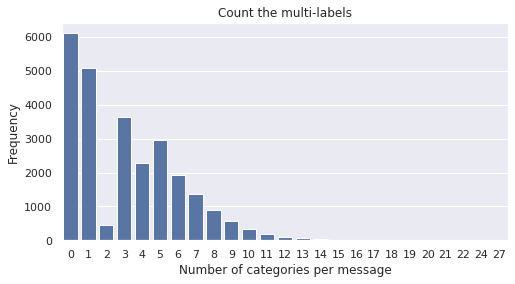

In [32]:
# choose one color as the base color
base_color = sns.color_palette()[0]

# rescale the figure size
plt.figure(figsize=[8,4])

# plot the horizontal bar chart
sns.barplot(x=row_sum_freq.index, y=row_sum_freq, color=base_color);

# label the axes
plt.xlabel('Number of categories per message');
plt.ylabel('Frequency');
plt.title('Count the multi-labels');

<div class="alert alert-block alert-info"> <b>NOTES:</b><br>
    1. The messages that have no label have been removed.<br>
    2. Only 5000 messages have one label, the remaining ones carry 2-27 labels. This indicates that we will have to treat this classification as a multi-label classification problem. 
 </div>

### Create a column to label the rows with no categories

In [33]:
# create a binary column to identify the messages with at least one  label
df['count_label'] = np.where(row_counts != 0, 1, 0)
df['count_label'].sum()

# compare the columns 'related' and 'count_label'
answer = df['related'].compare(df['count_label'], keep_shape=True, keep_equal=True)
# the two columns have identical entries
df.shape[0] - answer.shape[0]

# create a binary column to identify the messages with exactly one label
df['one_label'] = np.where(row_counts == 1, 1,0)
df['one_label'].sum()

# compare the columns 'related' and 'one_label'
answer_one = df['related'].compare(df['one_label'], keep_shape=True, keep_equal=True)
# the entries the two columns are distinct are given by 
df.shape[0] - answer_one.shape[0]

# drop the newly created columns 'count_label', 'one_label', use 'related' to identify messages with no labels
df.drop(columns=['count_label', 'one_label'], inplace=True)

<div class="alert alert-block alert-info"> <b>NOTES:</b> <br>
    The `related` column can be used to identify which messages have no labels. All these messages have entry 0 in the `related` column, all other messages have entry 1. Among the remaining messages, all have entry 1 in the 'related' column, of each 5072 have unique label 'related'.
 </div>

#### Alternate version: remove all messages with no labels

In [34]:
num_cols = df_opt.columns[2:]
df_opt = df_opt[df_opt[num_cols].sum(axis=1)!=0]
df_opt.shape

(14901, 36)

### Count frequencies and proportions along columns

In [35]:
# sum along each column to get the number of each category
df_col_counts = df.sum(axis = 0, skipna = True)

In [36]:
# get the message categories in decreasing order of frequencies
df_col_counts_ordered = df_col_counts[2:].sort_values(ascending=False)
# get the list of categories in decreasing order of frequencies
category_order = df_col_counts_ordered.index

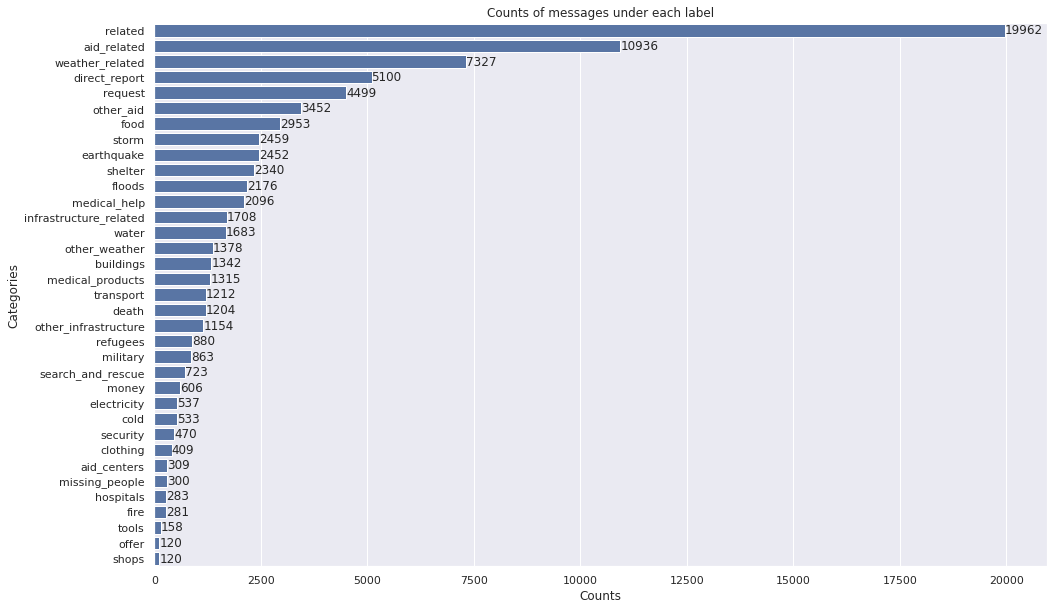

In [37]:
# choose one color as the base color
base_color = sns.color_palette()[0]

# rescale the figure size
plt.figure(figsize=[16,10])

# plot the horizontal bar chart
sns.barplot(y=category_order, x=df_col_counts_ordered, color=base_color);

# label the axes
plt.xlabel('Counts')
plt.ylabel('Categories')
#plt.title('Categories counts and proportions relative to corpus size')
plt.title('Counts of messages under each label')

# print the proportion text on the bars
for i in range (df_col_counts_ordered.shape[0]):
    count = df_col_counts_ordered[i]
    pct_string = '{}'.format(count)
    # convert count into a percentage, and then into string
    #pct_string = '{:0.1f}'.format(100*count/df.shape[0])
    # print the string value to right of the bar
    plt.text(count+1, i, pct_string, va='center')

<div class="alert alert-block alert-info"> <b>NOTES:</b><br>
    This is an highly imbalanced dataset. 
    </div>

### Investigate messages by length

In [38]:
# isolate the text messages
X = df['message']

In [39]:
# create a list of message length
len_strings = []
for message in X:
    len_strings.append(len(message))
    
# save the lengths as a panda series
len_strings = pd.Series(len_strings)

In [40]:
# create a dataframe which contains the length of the message and the corresponding frequency 
msg_length = pd.DataFrame(len_strings.value_counts().reset_index().values, columns=['Length', 'Frequency'])
# sort the output by frequency
msg_length = msg_length.sort_index(axis = 1, ascending=False)

In [41]:
# display a table with the 5 statistics for the frequencies of lengths
msg_length.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Length,588.0,661.81,1181.89,17.0,173.75,320.5,485.25,10818.0
Frequency,588.0,44.35,55.45,1.0,1.00,10.0,90.00,190.0


<div class="alert alert-block alert-info"> <b>NOTES:</b><br>
    Half of the messages are 320 characters or less, with roughly at most 80 words per message. The third quartile is at 485 characters, maybe around 100 words.
</div>

## Save the data

Save the clean datasets into sqlite databases. 

In [42]:
# path for the database
disaster_db = path / 'data/DisasterResponse.db'
# create engine and save the dataset
engine=create_engine(f'sqlite:///{disaster_db}')
df.to_sql('MessagesTable', engine, if_exists='replace', index=False)

In [43]:
# path for the alternate model database
dis_opt_db = path / 'data/DisasterResponseOpt.db'
# create engine and save the alternate dataset
engine_opt=create_engine(f'sqlite:///{dis_opt_db}')
df_opt.to_sql('DisasterResponseOpt', engine_opt, if_exists='replace', index=False)

## Generate a profiling report

In [ ]:
# run this once to generate the report and save it as html file

import pandas_profiling
profile = pandas_profiling.ProfileReport(df, minimal=True)

save_path = path / 'reports/'
filename = 'data_report.html'
filename = os.path.join(save_path, filename)
profile.to_file(output_file = filename)